## Monte Carlo simulation for two dimensional var-covar matrix estimation

### DGP

#### 2 dimensional array (matrix) with the following characteristics: 
Sparse, real valued, positive semidefinite, with weakly positive diagonal values.  
 
Note: Though we might not need to, this procedure is generalizable to multidimensional arrays as well. Conceptually, it would be stacking up n-1 dimensional array against each other to create an n dimensional array e.g. stcking up matrices against each other will create a 3d tensor. We can generate such arrays while controlling the correlations in our variables accross each additional dimension, and we can also impose restrictions on the diagonals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import pandas as pd
import os

In [2]:
def generate_diagonal_and_symmetric_elements_with_zero_probability(mu, sigma, k, non_zero_prob, seed):
    # Set the seed for reproducibility
    np.random.seed(seed)

    # Step 1: Generate a random lower triangular matrix from a normal distribution
    lower_triangular = np.random.normal(mu, sigma, (k, k))
    lower_triangular[np.triu_indices(k, k=1)] = 0.0  # Set upper triangle to zero

    # Step 2: Set elements to zero with a specified probability
    zero_probs = np.random.random((k,k))
    np.fill_diagonal(zero_probs, 0) # keep the diagonal elements
    lower_triangular[zero_probs > non_zero_prob] = 0

    # Step 3: generate a PSD matrix
    variance_covariance_matrix = np.dot(lower_triangular, lower_triangular.T)
    
    diagonal_vector = np.diagonal(variance_covariance_matrix)

    return diagonal_vector, variance_covariance_matrix

In [3]:
k = 10
mu = 2
sigma = 8
non_zero_prob = 0.02
seed = 42

In [4]:
# Generate the diagonal vector from a normal distribution
diagonal_vector, cov_matrix = generate_diagonal_and_symmetric_elements_with_zero_probability(mu, sigma, k, non_zero_prob, seed)

#### Sanity Check: Eigenvalues

In [5]:
def is_positive_semidefinite(matrix):
    eigenvalues, _ = np.linalg.eig(matrix)
    return np.all(eigenvalues >= 0)

result = is_positive_semidefinite(cov_matrix)

if result:
    print("The matrix is positive semidefinite.")
else:
    print("The matrix is not positive semidefinite.")

The matrix is positive semidefinite.


In [6]:
#print("Diagonal Vector:", diagonal_vector)
#print("Variance-Covariance Matrix ({}x{}):".format(k, k))
#print(cov_matrix)

#### Sample covariance Monte Carlo

This can be used as a benchmark

In [7]:
def generate_multivariate_data(cov_matrix, n, seed=None):
    # Get the dimension of the covariance matrix (number of variables)
    k = cov_matrix.shape[0]

    # Generate data from multivariate normal distribution with zero mean and the given covariance matrix
    data = np.random.multivariate_normal(mean=np.zeros(k), cov=cov_matrix, size=n)

    return data

In [8]:
def calculate_covariance_matrix(data):
    # Calculate the covariance matrix
    cov_matrix = np.cov(data, rowvar=False)

    return cov_matrix

In [9]:
def sample_covariance_bias_variance_rmse(true_cov_matrix, n, num_iterations, seed):
    np.random.seed(seed)

    # Initialize arrays to store bias, variance, and MSE for each element
    k = true_cov_matrix.shape[0]
    bias_sum = np.zeros((k, k))
    mse_sum = np.zeros((k, k))
    estimated_cov_matrices = []

    for _ in range(num_iterations):
        # Generate multivariate data
        data = generate_multivariate_data(true_cov_matrix, n)

        # Estimate covariance matrix
        estimated_cov_matrix = calculate_covariance_matrix(data)

        # Calculate bias and accumulate
        bias = true_cov_matrix - estimated_cov_matrix
        bias_sum += bias
        mse = bias ** 2
        mse_sum += mse

        # Save estimated covariance matrix
        estimated_cov_matrices.append(estimated_cov_matrix)

    # Calculate average bias and variance
    avg_bias = bias_sum / num_iterations
    stacked_matrices = np.stack(estimated_cov_matrices, axis=0)
    variance = np.var(stacked_matrices, axis=0)

    # Calculate MSE for each element of the covariance matrix
    avg_mse = mse_sum / num_iterations
    rmse = np.sqrt(mse)

    return avg_bias, variance, rmse

In [10]:
N = 3000
seed = 42
iterations = 1000

In [11]:
def calculate_matrix_average(matrix):
    return np.mean(matrix)

I could not think of a way to do this without using a loop, which I wanted to avoid, because loops tend to be quite slow. However, since it is a monte Carlo simulation, the order in which the iterations are executed does not matter, as long as we keep track of which sample size produces which results. Thus, I write down a sequential loop, then, the parallel equivalent. 

In [ ]:
biases = []
variances = []
rmses = []
sample_sizes = []
sample_covariance_results = pd.DataFrame(columns=['n', 'Bias', 'Variance', 'RMSE'])

for n in range(1, N+1, 20):
    # Calculate the bias, variance, and RMSE for the current sample size
    bias_mat, variance_mat, rmse_mat = sample_covariance_bias_variance_rmse(cov_matrix, n, iterations, seed)
    biases.append(calculate_matrix_average(bias_mat))
    variances.append(calculate_matrix_average(variance_mat))
    rmses.append(calculate_matrix_average(rmse_mat))
    sample_sizes.append(n)

    # Create a new DataFrame for the current iteration
    iteration_df = pd.DataFrame({'n': [n], 'Bias': [avg_bias], 'Variance': [avg_variance], 'RMSE': [avg_rmse]})

    # Concatenate the new DataFrame with the existing results_df
    sample_covariance_results = pd.concat([sample_covariance_results, iteration_df], ignore_index=True)

In [13]:
biases = []
variances = []
rmses = []
sample_sizes = []
sample_covariance_results = pd.DataFrame(columns=['n', 'Bias', 'Variance', 'RMSE'])

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit jobs for parallel processing
    futures = {executor.submit(sample_covariance_bias_variance_rmse, cov_matrix, n, iterations, seed): n for n in range(20, N+1, 20)}

    # Retrieve results as they become available
    for future in concurrent.futures.as_completed(futures):
        n = futures[future]
        bias_mat, variance_mat, rmse_mat = future.result()

        # Calculate the average bias, variance, and RMSE for the current iteration
        avg_bias = calculate_matrix_average(bias_mat)
        avg_variance = calculate_matrix_average(variance_mat)
        avg_rmse = calculate_matrix_average(rmse_mat)

        biases.append(avg_bias)
        variances.append(avg_variance)
        rmses.append(avg_variance)
        sample_sizes.append(n)

        # Create a new DataFrame for the current iteration
        iteration_df = pd.DataFrame({'n': [n], 'Bias': [avg_bias], 'Variance': [avg_variance], 'RMSE': [avg_rmse]})

        # Concatenate the new DataFrame with the existing results_df
        sample_covariance_results = pd.concat([sample_covariance_results, iteration_df], ignore_index=True)

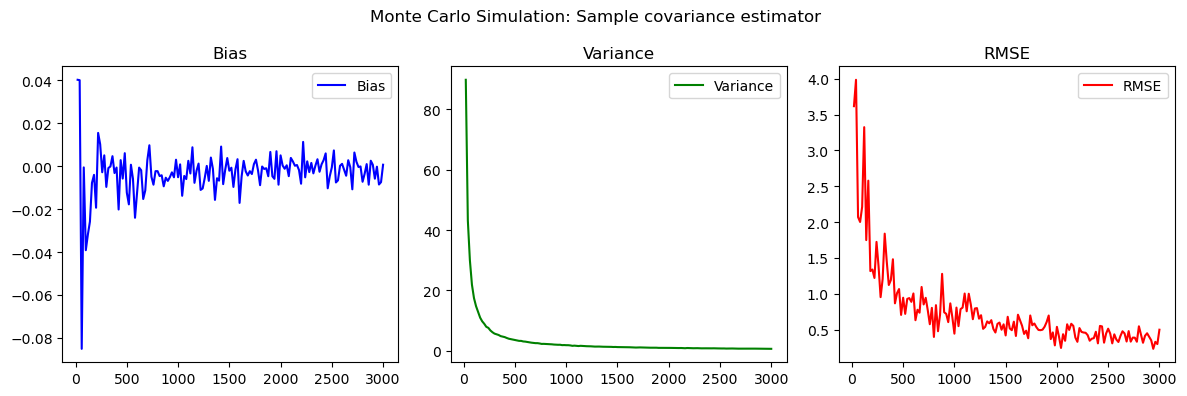

In [14]:
# Reorder the DataFrame by ascending 'SampleSize'
sample_covariance_results = sample_covariance_results.sort_values(by='n')

x = sample_covariance_results['n']
y1 = sample_covariance_results['Bias']
y2 = sample_covariance_results['Variance']
y3 = sample_covariance_results['RMSE']

# Create a figure and three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first vector in the first subplot
axs[0].plot(x, y1, label='Bias', color='blue')
axs[0].set_title('Bias')
axs[0].legend()

# Plot the second vector in the second subplot
axs[1].plot(x, y2, label='Variance', color='green')
axs[1].set_title('Variance')
axs[1].legend()

# Plot the third vector in the third subplot
axs[2].plot(x, y3, label='RMSE', color='red')
axs[2].set_title('RMSE')
axs[2].legend()

# Add a title to the whole plot
plt.suptitle('Monte Carlo Simulation: Sample covariance estimator')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Save the figure as PNG file
plt.savefig('../output/sample_cov_MC.png') 

# Show the plots
plt.show()